In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [164]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From github.com:mwalmsley/zoobot
   ae1591e..398b58d  al-iter    -> origin/al-iter
Updating ae1591e..398b58d
Fast-forward
 zoobot/estimators/make_predictions.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


In [38]:
import os
import logging
import argparse

import numpy as np
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
import pandas as pd

from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

/Data/repos/zoobot/zoobot/active_learning/simulation_timeline.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel/kernelapp.py"

In [32]:
model_name = 'five_conv_fractions_with_id'
tfrecord_loc = 'data/basic_split/panoptes_featured_s128_lfloat_test.tfrecord'
n_galaxies = 1024

In [33]:
results_dir = 'results'

save_dir = 'analysis/uncertainty/al-binomial/{}'.format(model_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

subjects_loc = os.path.join(save_dir, 'subjects.npy')
# labels_loc = os.path.join(save_dir, 'id_strs.npy')

In [39]:
images, id_strs, samples = check_uncertainty.calculate_predictions(tfrecord_loc, n_galaxies, results_dir, model_name)

INFO:tensorflow:Restoring parameters from results/five_conv_fractions_with_id/variables/variables


INFO:tensorflow:Restoring parameters from results/five_conv_fractions_with_id/variables/variables


In [59]:
subjects = [{'matrix': images[n], 'id_str': id_strs[n].decode('utf-8')} for n in range(len(id_strs))]
acquisitions = acquisition_utils.mutual_info_acquisition_func(samples)

In [61]:
metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=acquisitions)

In [62]:
# if new_predictions:
#     images, id_strs, samples = check_uncertainty.calculate_predictions(tfrecord_loc, n_galaxies, results_dir, model_name)
#     np.save(subjects_loc, subjects)
#     np.save(labels_loc, id_strs)
#     subjects = [{'matrix': images[n], 'id_str': id_strs[n]} for n in range(len(id_strs))]
#     metrics.save_iteration_state(save_dir, subjects, samples, acquisitions=None)

# else:
#     assert all(os.path.exists(loc) for loc in [subjects_loc, labels_loc])
#     subjects = np.load(subjects_loc)
# #     labels = np.load(labels_loc)



In [63]:
state = metrics.load_iteration_state(save_dir)

In [64]:
model = metrics.Model(state, name=model_name)

In [65]:
model.show_mutual_info_vs_predictions(save_dir)

In [66]:
# dummy catalog
# id_strs = np.arange(len(labels))
# data = [{'subject_id': str(id_str), 'smooth-or-featured_smooth_fraction': label} for id_str, label in zip(id_strs, labels)]
# catalog = pd.DataFrame(data)

In [67]:
simulation_timeline.ATTR_STRS 

['subject_id',
 'ra',
 'dec',
 'petroth50',
 'petrotheta',
 'redshift',
 'z',
 'absolute_size',
 'mag_g',
 'mag_r',
 'petroflux']

In [280]:
# add in catalog details for more metrics
spiral_strs = ['has-spiral-arms_yes', 'spiral-winding_prediction-encoded']
merger_strs = ['merging_merger','merging_tidal-debris-v1' ,'merging_both-v1','merging_neither-v1','merging_major-disturbance','merging_minor-disturbance','merging_none']
usecols = simulation_timeline.ATTR_STRS + ['subject_id', 'smooth-or-featured_smooth_fraction'] + merger_strs + spiral_strs + ['smooth-or-featured_artifact']
catalog = pd.read_csv('data/panoptes_predictions_selected.csv', usecols=usecols, dtype={'subject_id': str})

In [281]:
assert set(model.id_strs) - set(catalog['subject_id']) == set()

In [282]:
sim_model = simulated_metrics.SimulatedModel(model, catalog)

/Data/repos/zoobot/zoobot/active_learning/simulated_metrics.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  filtered_catalog['subject_id'] = filtered_catalog['subject_id'].astype(str)


In [510]:
def custom_samples(samples, labels):
    sns.set_context('paper', font_scale=1.5)
    fig, axes = plt.subplots(nrows=len(labels), figsize=(3, len(labels)*1.5), sharex=True)
    make_predictions.plot_samples(samples, labels, fig, axes)
    
    for n in range(len(labels)):
#         axes[n].set_ylabel(r'$p(v|D)$', visible=True)
        axes[n].set_ylabel(r'$p(v|w)$', visible=True)
        axes[n].yaxis.set_visible(True)
    
    axes[-1].set_xlabel('Volunteer Votes')
    fig.tight_layout()

    axes[0].legend(
        loc='lower center', 
        bbox_to_anchor=(0.5, 1.1),
        ncol=1, 
        fancybox=True, 
        shadow=False
    )
    fig.tight_layout()
    return fig


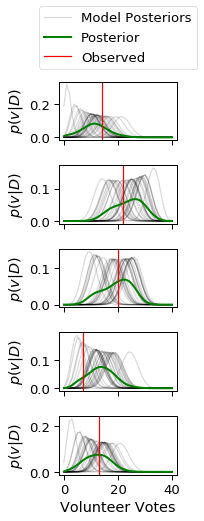

In [508]:
selected = slice(0, 20)
selected = [1, 2, 6, 7, 9]
# selected = [2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 18]
# selected = [2, 3, 4, 5, 6]

fig = custom_samples(np.array(sim_model.model.samples)[selected, :], np.array(sim_model.labels)[selected])

In [509]:
fig.savefig(os.path.join(save_dir, 'many_samples.png'))

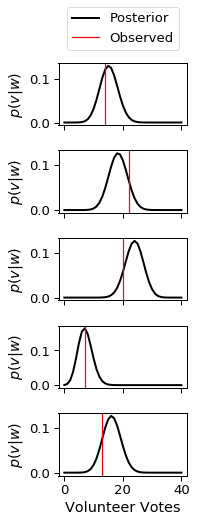

In [513]:
fig = custom_samples(np.array(sim_model.model.samples[selected, :1]), np.array(sim_model.labels[selected]))

In [514]:
fig.savefig(os.path.join(save_dir, 'one_sample.png'))

In [286]:
# acquisition_utils.save_acquisition_examples(model., model.mutual_info, 'mutual_info', save_dir)

In [287]:
# sim_model.show_coverage(save_dir)
# sim_model.compare_binomial_and_abs_error(save_dir)
sim_model.show_acquisition_vs_label(save_dir)

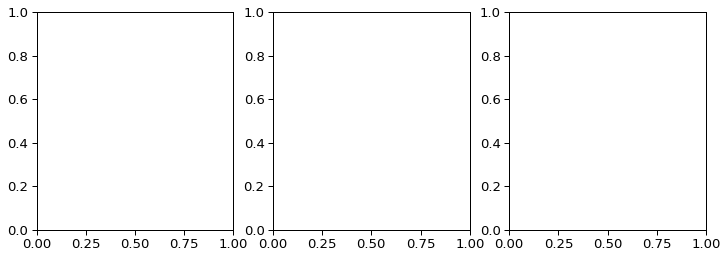

In [288]:
fig, row = plt.subplots(ncols=3, figsize=(12, 4))

In [289]:
row = sim_model.acquisition_vs_volunteer_votes(row)

In [379]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = gridspec.GridSpec(6, 5, figure=fig)

<Figure size 1440x864 with 0 Axes>

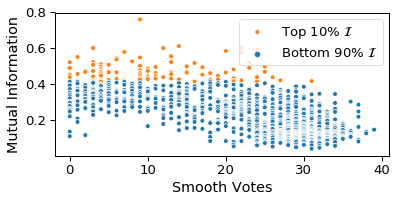

In [380]:
ax0 = plt.subplot(gs[:4, :])
sns.scatterplot(
    np.array(sim_model.catalog['smooth-or-featured_smooth_fraction'] * 40).astype(int),
    sim_model.model.mutual_info, hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103],
    ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Smooth Votes')
ax0.legend([r'Top 10% $\mathcal{I}$', r'Bottom 90% $\mathcal{I}$'])

Text(0.5,0,'Smooth Votes')

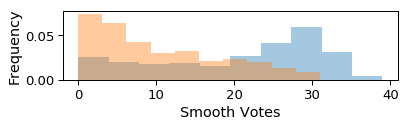

In [381]:
ax1 = plt.subplot(gs[4:, :])

ax1.hist(np.array(sim_model.labels * 40).astype(int), density=True, alpha=0.4)
ax1.hist(np.array(sim_model.labels * 40).astype(int)[:200], density=True, alpha=0.4)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Smooth Votes')

In [329]:
fig

<Figure size 432x288 with 0 Axes>

In [294]:
plt.show()

In [295]:
plt.savefig(os.path.join(save_dir, 'temp.png'))

<Figure size 432x288 with 0 Axes>

Text(0.5,0,'Volunteer Votes')

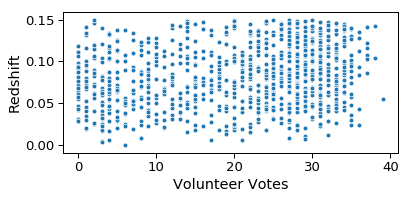

In [296]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

Text(0.5,0,'Volunteer Votes')

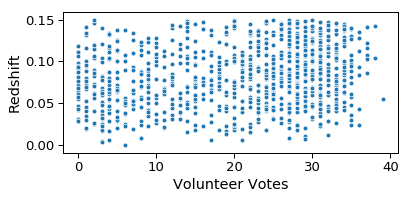

In [297]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(np.array(sim_model.labels * 40).astype(int), sim_model.catalog['redshift'], ax=ax0)
ax0.set_ylabel('Redshift')
ax0.set_xlabel('Volunteer Votes')

Text(0.5,0,'Redshift')

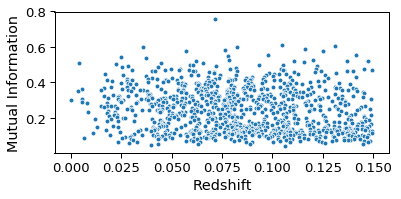

In [298]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog['redshift'], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel('Redshift')

In [299]:
merger_strs

['merging_merger',
 'merging_tidal-debris-v1',
 'merging_both-v1',
 'merging_neither-v1',
 'merging_major-disturbance',
 'merging_minor-disturbance',
 'merging_none']

In [388]:
merger_label = 'merging_major-disturbance'

Text(0.5,0,'merging_major-disturbance')

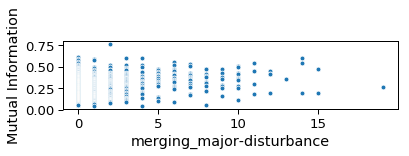

In [389]:
ax0 = plt.subplot(gs[:2, :])
sns.scatterplot(sim_model.catalog[merger_label], sim_model.model.mutual_info, ax=ax0)
ax0.set_ylabel('Mutual Information')
ax0.set_xlabel(merger_label)

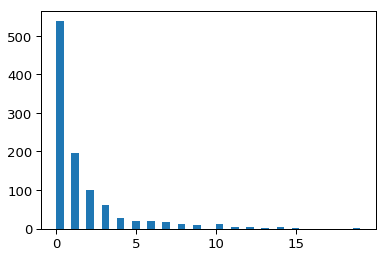

In [390]:
_ = plt.hist(sim_model.catalog[merger_label], bins=40)

In [303]:
featured_no_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] == 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]
featured_merger = sim_model.model.mutual_info[(sim_model.catalog[merger_label] > 0) & (sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.4)]

In [391]:
featured_no_merger.mean()

0.35118675761359064

In [393]:
featured_merger.mean()

0.3618340880786661

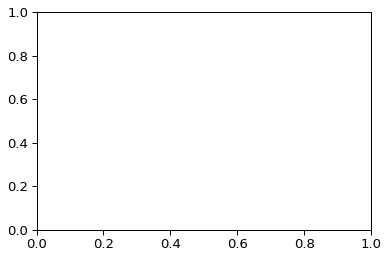

In [304]:
fig, ax = plt.subplots()

In [305]:
ax.hist(featured_no_merger, alpha=0.3, density=True)

(array([0.45991148, 0.30660766, 2.45286124, 3.98589952, 5.05902631,
        3.21938038, 2.45286124, 1.6863421 , 0.30660766, 0.30660766]),
 array([0.1173528 , 0.16676942, 0.21618604, 0.26560267, 0.31501929,
        0.36443592, 0.41385254, 0.46326916, 0.51268579, 0.56210241,
        0.61151903]),
 <a list of 10 Patch objects>)

In [306]:
ax.hist(featured_merger, alpha=0.3, density=True)

(array([0.24229288, 0.88840723, 2.90751457, 4.84585761, 3.63439321,
        1.85757875, 0.80764294, 0.16152859, 0.        , 0.08076429]),
 array([0.11109103, 0.17591673, 0.24074243, 0.30556813, 0.37039384,
        0.43521954, 0.50004524, 0.56487095, 0.62969665, 0.69452235,
        0.75934805]),
 <a list of 10 Patch objects>)

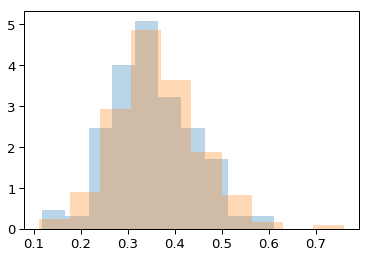

In [307]:
fig

(0, 14.5)

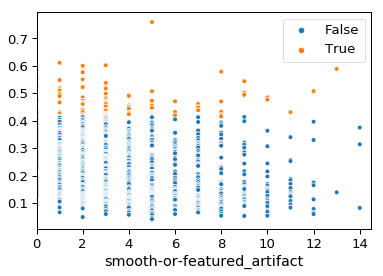

In [385]:
ax = sns.scatterplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info, 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[103])
ax.set_xlim([0, 14.5])

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


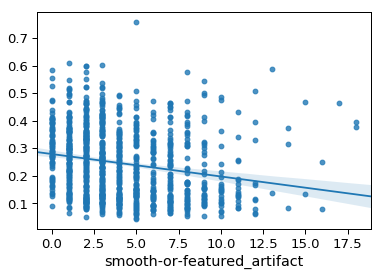

In [309]:
sns.regplot(
    sim_model.catalog['smooth-or-featured_artifact'], 
    sim_model.model.mutual_info)

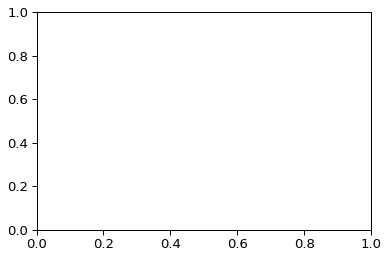

In [310]:
fig, ax = plt.subplots()

In [311]:
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['smooth-or-featured_artifact'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([0.11014807, 0.17515349, 0.11616709, 0.07162634, 0.0288913 ,
        0.03310461, 0.01504755, 0.00240761, 0.00180571, 0.0012038 ]),
 array([ 0. ,  1.8,  3.6,  5.4,  7.2,  9. , 10.8, 12.6, 14.4, 16.2, 18. ]),
 <a list of 10 Patch objects>)

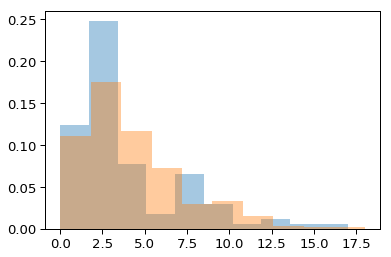

In [312]:
fig

In [313]:
has-spiral-arms_yes
spiral-winding_prediction-encoded

NameError: name 'has' is not defined

In [318]:
sns.scatterplot(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    sim_model.model.mutual_info[sim_model.catalog['smooth-or-featured_smooth_fraction'] < 0.5], 
    hue=sim_model.model.mutual_info > sim_model.model.mutual_info[100])

ValueError: arrays must all be same length

(array([0.16495125, 0.02004334, 0.00893824, 0.01110509, 0.00731311,
        0.00270856, 0.0067714 , 0.01110509, 0.00839653, 0.00866739]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

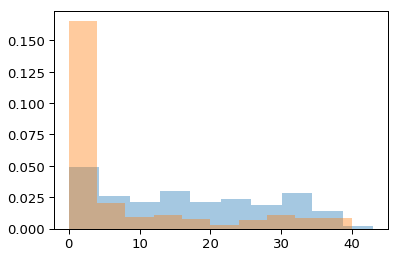

In [316]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['has-spiral-arms_yes'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([ 0.94125923,  4.05465512,  5.5751508 ,  7.24045558,  9.41259225,
        12.01915626,  7.45766925,  8.32652391,  5.71995991,  6.08198269]),
 array([9.04981134e-05, 1.50539712e-02, 3.00174442e-02, 4.49809172e-02,
        5.99443903e-02, 7.49078633e-02, 8.98713364e-02, 1.04834809e-01,
        1.19798282e-01, 1.34761756e-01, 1.49725229e-01]),
 <a list of 10 Patch objects>)

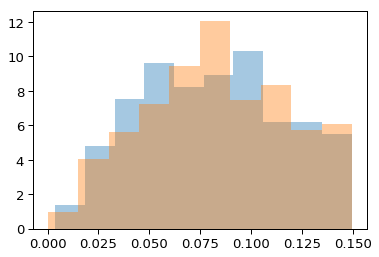

In [386]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['redshift'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

(array([0.38889206, 0.08211211, 0.0222387 , 0.01539602, 0.00798312,
        0.00570223, 0.00228089, 0.00114045, 0.        , 0.00057022]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

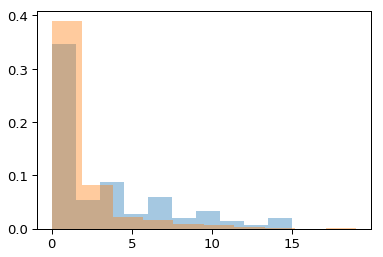

In [387]:
fig, ax = plt.subplots()
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info > sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)
ax.hist(
    sim_model.catalog['merging_major-disturbance'][sim_model.model.mutual_info < sim_model.model.mutual_info[100]],
    density=True,
    alpha=0.4,
)

In [455]:
for merger_label in merger_strs:
    print('\n' + merger_label)
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] > 1].mean())
    print(sim_model.model.mutual_info[sim_model.catalog[merger_label] == 1].mean())


merging_merger
0.2511509739575972
0.25096607272032195

merging_tidal-debris-v1
0.3034175803458046
0.23293615612694835

merging_both-v1
0.3219326360535824
0.26581695784524834

merging_neither-v1
0.24475130393558714
0.3423252674734375

merging_major-disturbance
0.2972217606913461
0.23137436019256713

merging_minor-disturbance
0.260792108234764
0.20166867936737748

merging_none
0.24643256291318852
0.24930844070251124


In [478]:
data = [
    {'Volunteer Response': 'Merging', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_both-v1'] > 1].mean()},
    {'Volunteer Response': 'Major Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_major-disturbance'] > 1].mean()},
    {'Volunteer Response': 'Minor Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_minor-disturbance'] > 1].mean()},
    {'Volunteer Response': 'No Disturbance', 'Mean Mutual Information': sim_model.model.mutual_info[sim_model.catalog['merging_none'] > 20].mean()}
    ]

In [479]:
df = pd.DataFrame(data)

In [480]:
df.head()

,Mean Mutual Information,Volunteer Response
0,0.321933,Merging
1,0.297222,Major Disturbance
2,0.260792,Minor Disturbance
3,0.219533,No Disturbance


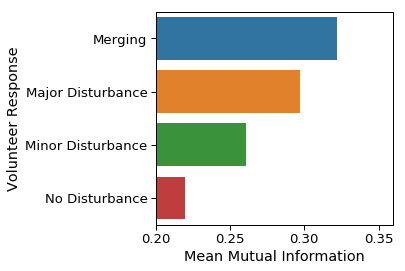

In [481]:
fig, ax = plt.subplots()
ax = sns.barplot(data=df, y='Volunteer Response', x='Mean Mutual Information', ax=ax)
ax.set_xlim([0.2, 0.36])
fig.tight_layout()

In [406]:
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) > 0].mean())
print(sim_model.model.mutual_info[(sim_model.catalog['merging_minor-disturbance'] + sim_model.catalog['merging_major-disturbance']) == 0].mean())

0.25065622588200587
0.2357066434226222


(array([602., 155.,   0.,  94.,   0.,  57.,   0.,  33.,   0.,  19.,   0.,
         13.,   0.,  16.,   0.,   9.,   0.,   6.,   0.,   4.,   5.,   0.,
          2.,   0.,   2.,   0.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.   ,  0.525,  1.05 ,  1.575,  2.1  ,  2.625,  3.15 ,  3.675,
         4.2  ,  4.725,  5.25 ,  5.775,  6.3  ,  6.825,  7.35 ,  7.875,
         8.4  ,  8.925,  9.45 ,  9.975, 10.5  , 11.025, 11.55 , 12.075,
        12.6  , 13.125, 13.65 , 14.175, 14.7  , 15.225, 15.75 , 16.275,
        16.8  , 17.325, 17.85 , 18.375, 18.9  , 19.425, 19.95 , 20.475,
        21.   ]),
 <a list of 40 Patch objects>)

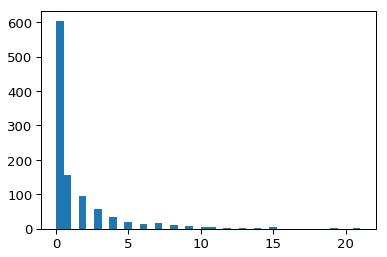

In [407]:
plt.hist(sim_model.catalog['merging_tidal-debris-v1'], bins=40)

0.2705853379023123

0.22372988551706502